# HW3: Variational Autoencoders

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions import Normal
from itertools import chain
from torchlib.generative_model.autoencoder.vae import VAE
from torchlib.dataset.utils import create_data_loader
from torchlib.utils.distributions import IndependentNormal
from sklearn.model_selection import train_test_split
from torchlib.common import FloatTensor, move_tensor_to_gpu
import matplotlib.pyplot as plt

Enable cuda True


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%qtconsole

## VAEs in 2D

### Part A

In [4]:
import numpy as np
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [5]:
data_1 = sample_data_1().astype(np.float32)
data_1_loader = create_data_loader((data_1,), batch_size=1024)
data_2 = sample_data_2().astype(np.float32)
data_2_loader = create_data_loader((data_2,), batch_size=1024)

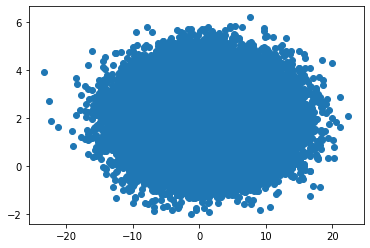

In [6]:
# visualize data distribution
plt.scatter(data_1[:, 0], data_1[:, 1])

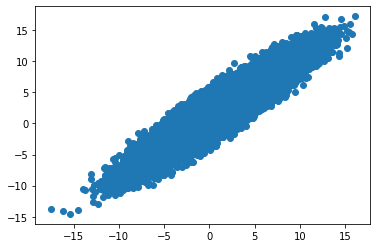

In [7]:
# visualize data distribution
plt.scatter(data_2[:, 0], data_2[:, 1])

### Define prior

In [8]:
prior = Normal(loc=torch.zeros(2).type(FloatTensor), scale=torch.ones(2).type(FloatTensor))

### Define encoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, code_size=2, nn_size=32):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
            nn.Linear(nn_size, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
            nn.Linear(nn_size, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
        )

        self.mu = nn.Linear(nn_size, code_size)
        self.logvar = nn.Linear(nn_size, code_size)

    def forward(self, x):
        x = self.model(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return Normal(mu, torch.exp(logvar))

### Define decoder

In [12]:
class Decoder_1(nn.Module):
    def __init__(self, code_size=2, nn_size=32):
        super(Decoder_1, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(code_size, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
            nn.Linear(nn_size, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
            nn.Linear(nn_size, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
        )
        
        self.mu = nn.Linear(nn_size, code_size)
        self.logvar = nn.Linear(nn_size, code_size)

    def forward(self, x):
        x = self.model(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return IndependentNormal(mu, torch.exp(logvar))
        
        
class Decoder_2(nn.Module):
    def __init__(self, code_size=2, nn_size=32):
        super(Decoder_2, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(code_size, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
            nn.Linear(nn_size, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
            nn.Linear(nn_size, nn_size),
            nn.BatchNorm1d(nn_size),
            nn.ReLU(),
        )
        
        self.mu = nn.Linear(nn_size, code_size)
        self.logvar = nn.Linear(nn_size, 1)

    def forward(self, x):
        x = self.model(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return IndependentNormal(mu, torch.exp(logvar))

### Fit on dataset 1 using diag normal decoder

In [13]:
encoder = Encoder()
decoder = Decoder_1()
optimizer = optim.Adam(chain(encoder.parameters(), 
                             decoder.parameters()), lr=1e-3)
model = VAE(encoder, decoder, prior, optimizer)
model.train(num_epoch=20, train_data_loader=data_1_loader, verbose=False)

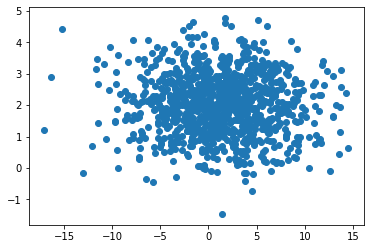

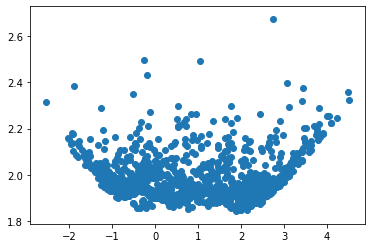

In [14]:
full_path_samples = model.sample(1000, full_path=True).cpu().numpy()
plt.figure()
plt.scatter(full_path_samples[:, 0], full_path_samples[:, 1])
no_decoder_noise_samples = model.sample(1000, full_path=False).cpu().numpy()
plt.figure()
plt.scatter(no_decoder_noise_samples[:, 0], no_decoder_noise_samples[:, 1])

### Fit on dataset 2 using diag normal decoder

In [15]:
encoder = Encoder()
decoder = Decoder_1()
optimizer = optim.Adam(chain(encoder.parameters(), 
                             decoder.parameters()), lr=1e-3)
model = VAE(encoder, decoder, prior, optimizer)
model.train(num_epoch=20, train_data_loader=data_2_loader, verbose=False)

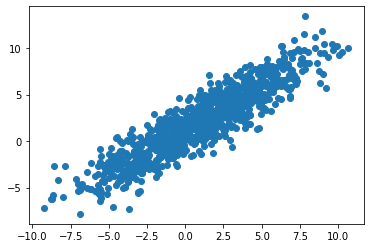

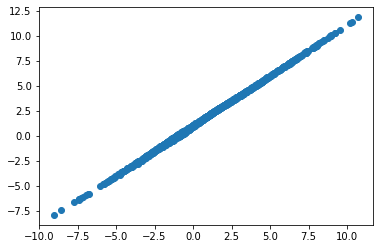

In [16]:
full_path_samples = model.sample(1000, full_path=True).cpu().numpy()
plt.figure()
plt.scatter(full_path_samples[:, 0], full_path_samples[:, 1])
no_decoder_noise_samples = model.sample(1000, full_path=False).cpu().numpy()
plt.figure()
plt.scatter(no_decoder_noise_samples[:, 0], no_decoder_noise_samples[:, 1])

### Fit on dataset 1 using single sigma decoder

In [17]:
encoder = Encoder()
decoder = Decoder_2()
optimizer = optim.Adam(chain(encoder.parameters(), 
                             decoder.parameters()), lr=1e-3)
model = VAE(encoder, decoder, prior, optimizer)
model.train(num_epoch=20, train_data_loader=data_1_loader, verbose=False)

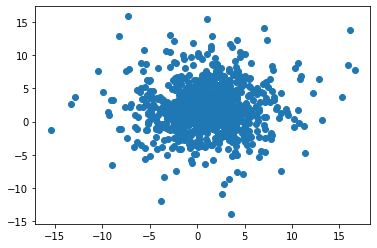

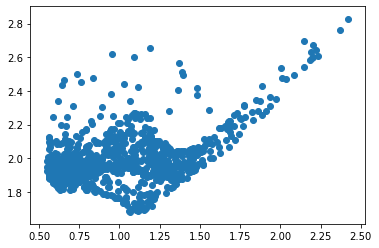

In [18]:
full_path_samples = model.sample(1000, full_path=True).cpu().numpy()
plt.figure()
plt.scatter(full_path_samples[:, 0], full_path_samples[:, 1])
no_decoder_noise_samples = model.sample(1000, full_path=False).cpu().numpy()
plt.figure()
plt.scatter(no_decoder_noise_samples[:, 0], no_decoder_noise_samples[:, 1])

### Fit on dataset 2 using single sigma decoder

In [19]:
encoder = Encoder()
decoder = Decoder_2()
optimizer = optim.Adam(chain(encoder.parameters(), 
                             decoder.parameters()), lr=1e-3)
model = VAE(encoder, decoder, prior, optimizer)
model.train(num_epoch=20, train_data_loader=data_2_loader, verbose=False)

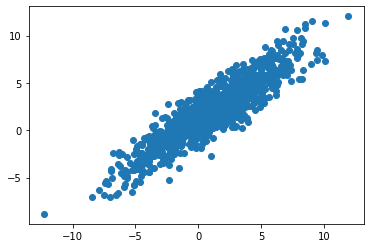

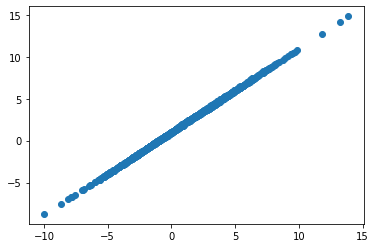

In [20]:
full_path_samples = model.sample(1000, full_path=True).cpu().numpy()
plt.figure()
plt.scatter(full_path_samples[:, 0], full_path_samples[:, 1])
no_decoder_noise_samples = model.sample(1000, full_path=False).cpu().numpy()
plt.figure()
plt.scatter(no_decoder_noise_samples[:, 0], no_decoder_noise_samples[:, 1])

### Part B

In [21]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)), 
              -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [22]:
data_3, data_3_label = sample_data_3()

data_3 = data_3.astype(np.float32)

data_3_train, data_3_test, data_3_train_label, data_3_test_label = train_test_split(
    data_3, data_3_label, test_size=0.2)

data_3_train_loader = create_data_loader((data_3_train, data_3_train_label), batch_size=1024)
data_3_test_loader = create_data_loader((data_3_test, data_3_test_label), batch_size=1024,
                                       shuffle=False, drop_last=False)

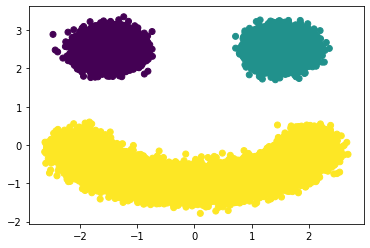

In [23]:
plt.scatter(data_3[:, 0], data_3[:, 1], c=data_3_label)

In [44]:
encoder = Encoder(nn_size=512)
decoder = Decoder_1(nn_size=512)
optimizer = optim.Adam(chain(encoder.parameters(), 
                             decoder.parameters()), lr=1e-3)
model = VAE(encoder, decoder, prior, optimizer)
model.train(num_epoch=100, train_data_loader=data_3_train_loader, verbose=False)

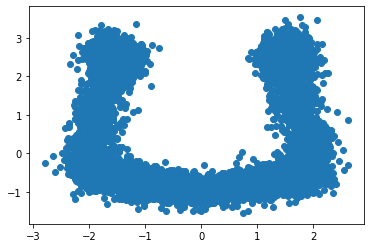

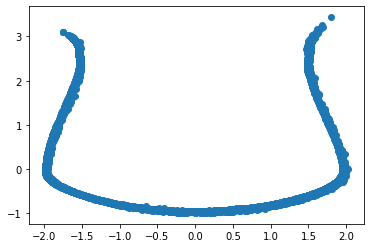

In [45]:
full_path_samples = model.sample(10000, full_path=True).cpu().numpy()
plt.figure()

plt.scatter(full_path_samples[:, 0], full_path_samples[:, 1])
no_decoder_noise_samples = model.sample(10000, full_path=False).cpu().numpy()
plt.figure()
plt.scatter(no_decoder_noise_samples[:, 0], no_decoder_noise_samples[:, 1])

### Visualize Latent of training data

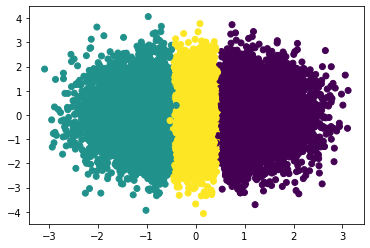

In [46]:
with torch.no_grad():
    latent = []
    for data in data_3_test_loader:
        data = move_tensor_to_gpu(data[0])
        latent.append(model.encode_reparm(data))
    latent = torch.cat(latent, dim=0).cpu().numpy()
plt.scatter(latent[:, 0], latent[:, 1], c=data_3_test_label)